In [1]:
import datetime as dt

from IPython.display import Image

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from scipy.stats import randint as sp_randint

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with statistically assigned labels)

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

In [3]:
ranges_m = [0.3, 0.7]
quantiles_m = customer_profile.quantile(q=ranges_m)
quantiles_m['RMonetary']

0.3      7.145611
0.7    127.860000
Name: RMonetary, dtype: float64

In [4]:
ranges_d = [0.3, 0.7]
quantiles_d = customer_profile.quantile(q=ranges_d)
quantiles_d['Delta']

0.3      1.0
0.7    224.0
Name: Delta, dtype: float64

In [5]:
ranges_r = [0.3, 0.8]
quantiles_r = customer_profile.quantile(q=ranges_r)
quantiles_r['Recency']

0.3     22.0
0.8    179.0
Name: Recency, dtype: float64

In [6]:
def ScoreM(x, data, thresh):
    if x <= thresh[data][ranges_m[0]]:
        return 1
    elif x <= thresh[data][ranges_m[1]]:
        return 2
    else:
        return 3

def ScoreD(x, data, thresh):
    if x <= thresh[data][ranges_d[0]]:
        return 1
    elif x <= thresh[data][ranges_d[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh):
    if x <= thresh[data][ranges_r[0]]:
        return 3
    elif x <= thresh[data][ranges_r[1]]:
        return 2
    else:
        return 1

In [7]:
customer_profile['MScore'] = customer_profile['RMonetary'].apply(ScoreM, args=('RMonetary', quantiles_m))
customer_profile['DScore'] = customer_profile['Delta'].apply(ScoreD, args=('Delta', quantiles_d))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r))
customer_profile['Score'] = (0.3 * customer_profile['MScore']
                           + 0.4 * customer_profile['DScore']
                           + 0.3 * customer_profile['RScore'])
#customer_profile.describe()

In [8]:
ranges = [0.2, 0.7]
quantiles = customer_profile.quantile(q=ranges)
#quantiles

In [9]:
def Score(x, data, thresh):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [10]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles))
customer_labeled.head()

df_majority = customer_labeled[customer_labeled.Label == 'Medium']
df_minority = customer_labeled[customer_labeled.Label == 'High']
df_middle   = customer_labeled[customer_labeled.Label == 'Low']

customer_labeled.Label.value_counts()

Medium    2110
High      1231
Low        981
Name: Label, dtype: int64

In [11]:
'''customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)
customer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)'''

"customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)\ncustomer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)"

In [12]:
'''fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],
           c=customer_labeled['Label_num'])
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative Monetary')
plt.show()'''

"fig = plt.figure()\nax = Axes3D(fig)\nax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],\n           c=customer_labeled['Label_num'])\nax.set_xlabel('Delta')\nax.set_ylabel('Recency')\nax.set_zlabel('Relative Monetary')\nplt.show()"

In [13]:
# Upsample minority classes

df_minority_upsampled = resample(df_minority,
                                 replace=True, # sample with replacement
                                 n_samples=len(df_majority))

df_middle_upsampled = resample(df_middle,
                               replace=True,
                               n_samples=len(df_majority))

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_labeled = df_upsampled
df_upsampled.Label.value_counts()

Low       2110
High      2110
Medium    2110
Name: Label, dtype: int64

In [14]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize

def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [15]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore
customer_labeled = customer_labeled[['Recency', 'RFrequency', 'Max_items', 'Label_num']]

label = customer_labeled.pop('Label_num')

scaler = MinMaxScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_labeled, label, stratify=label, test_size=0.3)

In [16]:
train_label.head()

2069    2
3997    2
4217    2
3531    2
3765    0
Name: Label_num, dtype: int64

## Expected prediction

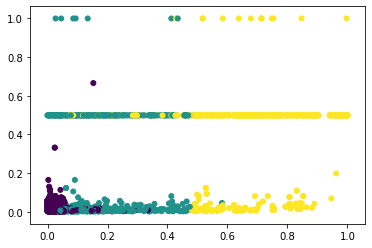

In [17]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_label.values, s=25)

## Decision Tree

In [18]:
# Decision tree

param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "criterion": ["entropy", "gini"],
              "splitter": ["best", "random"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()
grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))


grid_search.fit(train_set, train_label)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
       

In [19]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 48, 'min_samples_split': 23, 'splitter': 'random'}
Mean and std of this setting  0.8302846992296555 0.032357980749829526


In [53]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=5,
                                  min_samples_split=23, min_samples_leaf=48)

dec_t = dec_t.fit(train_set, train_label)

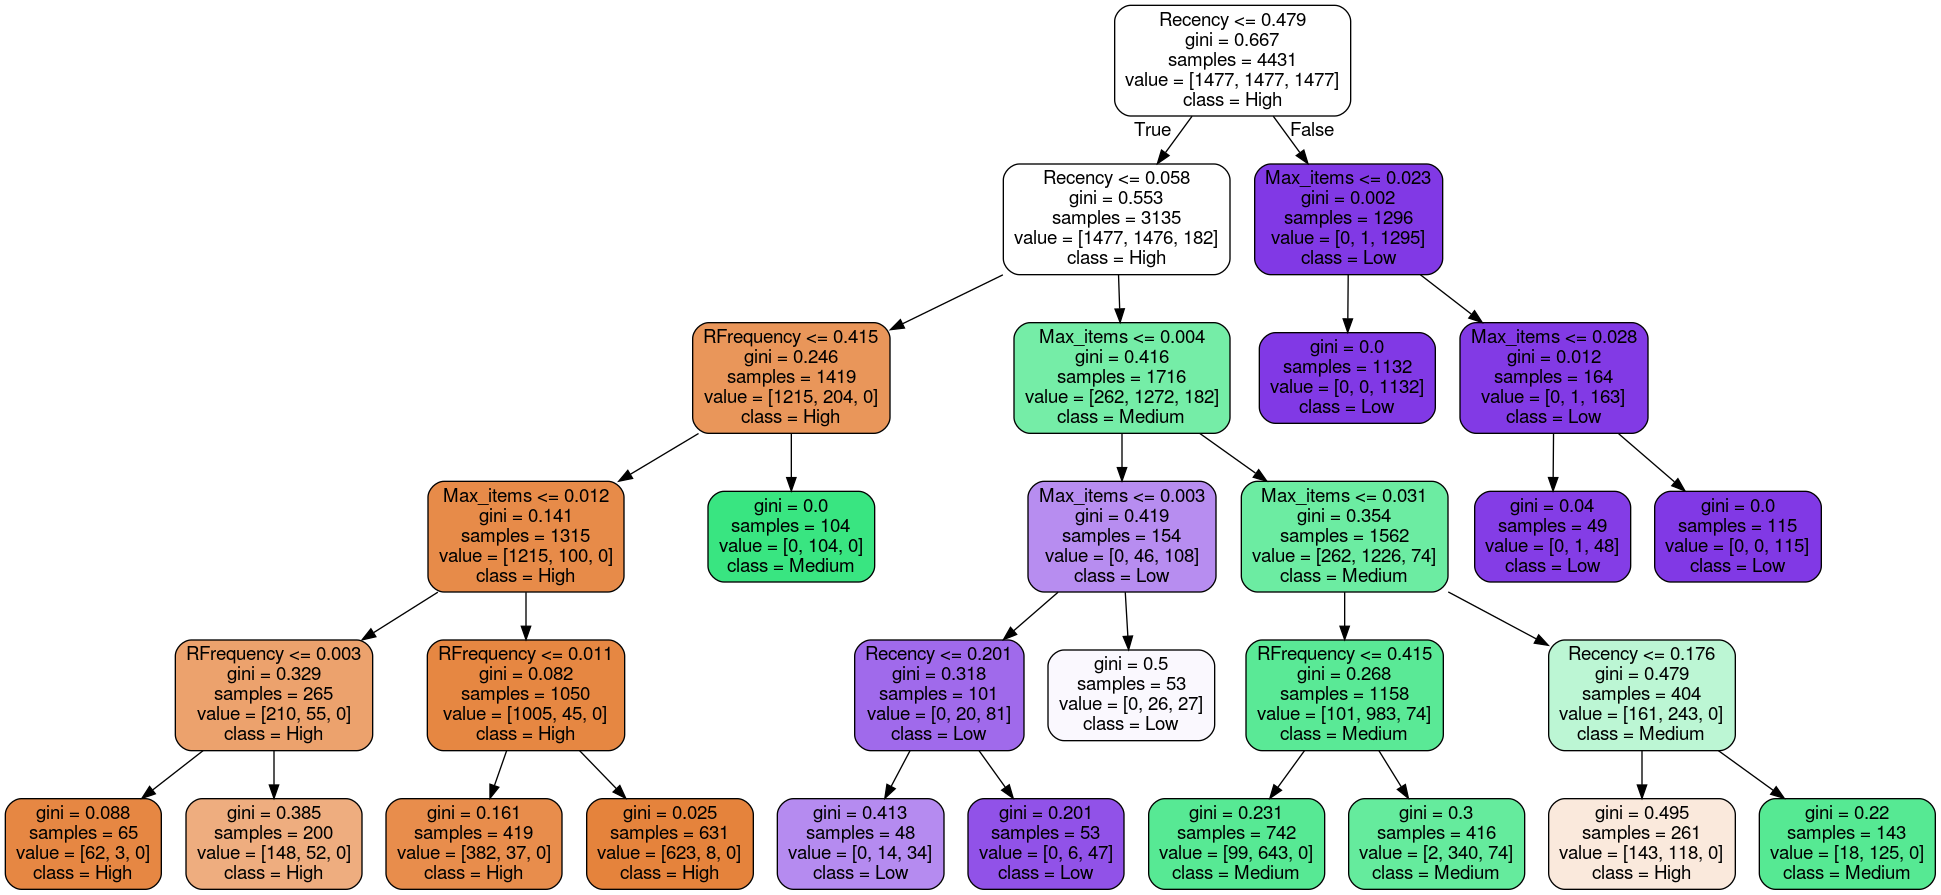

In [54]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Recency', 'RFrequency', 'Max_items'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [55]:
# Predict phase

train_pred_dt = dec_t.predict(train_set)
test_pred_dt = dec_t.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [56]:
# Evaulate the accuracy and F1 score on the train set and the test set

print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred_dt))
print()
print('F1 score train set:', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('F1 score test set: ', metrics.f1_score(test_label, test_pred_dt, average='weighted'))

#print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set: 0.8966373279169487
Accuracy test set:  0.9004739336492891

F1 score train set: 0.8964533655734216
F1 score test set:  0.9000899910088155


In [57]:
from sklearn.metrics import classification_report

print('Train:')
print(classification_report(train_label,
                            train_pred_dt,
                            target_names=['High', 'Medium','Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_dt,
                            target_names=['High', 'Medium','Low']))

Train:
              precision    recall  f1-score   support

        High       0.86      0.92      0.89      1477
      Medium       0.86      0.82      0.84      1477
         Low       0.97      0.95      0.96      1477

    accuracy                           0.90      4431
   macro avg       0.90      0.90      0.90      4431
weighted avg       0.90      0.90      0.90      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.88      0.93      0.90       633
      Medium       0.87      0.83      0.85       633
         Low       0.95      0.95      0.95       633

    accuracy                           0.90      1899
   macro avg       0.90      0.90      0.90      1899
weighted avg       0.90      0.90      0.90      1899



In [58]:
# cross validation
# the score array for test/train scores on each cv split
# the time for fitting/scoring the estimator on the train set for each cv split

from sklearn.model_selection import cross_validate
import statistics 

scores = cross_validate(dec_t, train_set, train_label, cv=3, return_train_score=True)

print('Fit time:   ', statistics.mean(scores['fit_time']))
print('Score time: ', statistics.mean(scores['score_time']))
print('Test score: ', statistics.mean(scores['test_score']))
print('Train score:', statistics.mean(scores['train_score']))

Fit time:    0.0062215328216552734
Score time:  0.001047690709431966
Test score:  0.8948318663958474
Train score: 0.8977657413676371


In [59]:
# compute confusion matrix

from sklearn.metrics import confusion_matrix

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1358  119    0]
 [ 218 1212   47]
 [   0   74 1403]]
------------------
Test:
[[587  46   0]
 [ 79 524  30]
 [  0  34 599]]


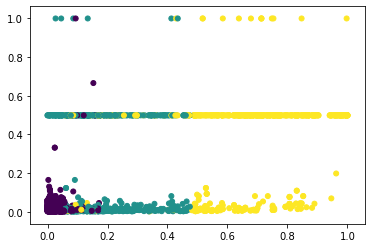

In [60]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_dt, s=25)

## SVM

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm =  SVC(kernel='poly', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

svm_binarize =  OneVsRestClassifier(SVC(kernel='poly', C=0.5, gamma='scale'))
svm_binarize.fit(train_set, train_label_binarized)

OneVsRestClassifier(estimator=SVC(C=0.5, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='poly', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [29]:
# Predictions

train_pred_svm_binarized = svm_binarize.predict(train_set)
test_pred_svm_binarized = svm_binarize.predict(test_set)

train_pred_svm = svm.predict(train_set)
test_pred_svm = svm.predict(test_set)

In [30]:
# Compute the performance of the model

print('Train:')
print(classification_report(train_label,
                            train_pred_svm,
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_svm,
                            target_names=['High', 'Medium', 'Low']))
                            

Train:
              precision    recall  f1-score   support

        High       0.69      0.98      0.81      1477
      Medium       0.81      0.52      0.63      1477
         Low       0.95      0.89      0.92      1477

    accuracy                           0.80      4431
   macro avg       0.82      0.80      0.79      4431
weighted avg       0.82      0.80      0.79      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.71      0.98      0.82       633
      Medium       0.81      0.55      0.65       633
         Low       0.95      0.89      0.92       633

    accuracy                           0.81      1899
   macro avg       0.82      0.81      0.80      1899
weighted avg       0.82      0.81      0.80      1899



/home/alessio/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


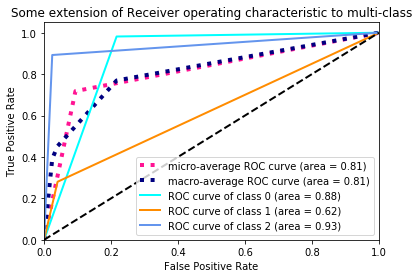

In [31]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

n_classes = 3
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

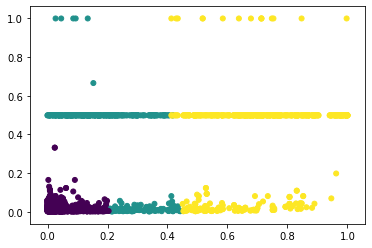

In [32]:
# x: Frequency
# y: Max items
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_svm, s=25)

## KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [34]:
train_pred_knn = knn.predict(train_set)
test_pred_knn = knn.predict(test_set)

In [35]:
print('Train:')
print(classification_report(train_label,
                            train_pred_knn,
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_knn,
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.88      0.98      0.93      1477
      Medium       0.96      0.84      0.90      1477
         Low       0.98      0.98      0.98      1477

    accuracy                           0.94      4431
   macro avg       0.94      0.94      0.93      4431
weighted avg       0.94      0.94      0.93      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.88      0.97      0.92       633
      Medium       0.91      0.83      0.87       633
         Low       0.96      0.95      0.96       633

    accuracy                           0.92      1899
   macro avg       0.92      0.92      0.92      1899
weighted avg       0.92      0.92      0.92      1899



## Classification with Random Forest

In [36]:
# Define and fit a random forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 

rf = rf.fit(train_set, train_label)

In [37]:
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

In [38]:
print('Train:')
print(classification_report(train_label,
                            train_pred_rf,
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_rf,
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.92      0.82      0.87      1477
      Medium       0.81      0.91      0.86      1477
         Low       0.97      0.97      0.97      1477

    accuracy                           0.90      4431
   macro avg       0.90      0.90      0.90      4431
weighted avg       0.90      0.90      0.90      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.94      0.82      0.88       633
      Medium       0.81      0.91      0.85       633
         Low       0.96      0.96      0.96       633

    accuracy                           0.90      1899
   macro avg       0.90      0.90      0.90      1899
weighted avg       0.90      0.90      0.90      1899



In [39]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1,len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.25, 1: 0.50, 2:0.25}]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [40]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 33, 'min_samples_split': 23}
Mean and std of this setting  0.8927994279039346 0.011116354667904364


In [41]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             class_weight= 'balanced',
                             max_depth=2, 
                             min_samples_split=12,
                             min_samples_leaf=41,
                             bootstrap=False) 
rf = rf.fit(train_set, train_label)

In [42]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [43]:
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_rf,
                            target_names=['High', 'Medium', 'Low']))

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.87      0.82      0.84       633
      Medium       0.74      0.87      0.80       633
         Low       1.00      0.87      0.93       633

    accuracy                           0.85      1899
   macro avg       0.87      0.85      0.86      1899
weighted avg       0.87      0.85      0.86      1899



## Neural networks

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1, len(customer_labeled[0]))))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [46]:
history = model.fit(train_set, train_label_nn,
                    epochs=40,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/40
13/13 [==============================] - 1s 37ms/step - loss: 1.0663 - accuracy: 0.4407 - val_loss: 1.0324 - val_accuracy: 0.6444
Epoch 2/40
13/13 [==============================] - 0s 6ms/step - loss: 1.0176 - accuracy: 0.6406 - val_loss: 0.9721 - val_accuracy: 0.6496
Epoch 3/40
13/13 [==============================] - 0s 7ms/step - loss: 0.9564 - accuracy: 0.6581 - val_loss: 0.8954 - val_accuracy: 0.6639
Epoch 4/40
13/13 [==============================] - 0s 6ms/step - loss: 0.8818 - accuracy: 0.6679 - val_loss: 0.8106 - val_accuracy: 0.6835
Epoch 5/40
13/13 [==============================] - 0s 7ms/step - loss: 0.7976 - accuracy: 0.6802 - val_loss: 0.7300 - val_accuracy: 0.6842
Epoch 6/40
13/13 [==============================] - 0s 6ms/step - loss: 0.7310 - accuracy: 0.6929 - val_loss: 0.6524 - val_accuracy: 0.7008
Epoch 7/40
13/13 [==============================] - 0s 7ms/step - loss: 0.6606 - accuracy: 0.7109 - val_loss: 0.5792 - val_accuracy: 0.7564
Epoch 8/40
13/13 [=

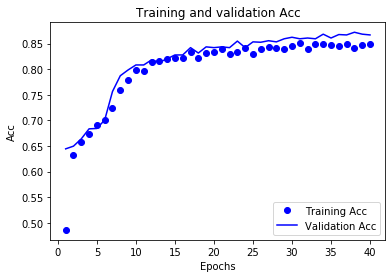

In [47]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [48]:
test_pred_nn = model.predict_classes(test_set)
test_pred_nn

/home/alessio/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([2, 0, 1, ..., 0, 0, 2])

In [49]:
#compute the performance of the model

print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_nn, 
                            target_names=['High', 'Medium', 'Low']))

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.87      0.91      0.89       633
      Medium       0.80      0.83      0.81       633
         Low       0.95      0.88      0.92       633

    accuracy                           0.87      1899
   macro avg       0.88      0.87      0.87      1899
weighted avg       0.88      0.87      0.87      1899



## Classification with Naive Bayes

In [50]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

train_pred_gnb = gnb.predict(train_set)
test_pred_gnb = gnb.predict(test_set)

In [51]:
print('Train:')
print(classification_report(train_label,
                            train_pred_gnb, 
                            target_names=['High', 'Medium', 'Low']))
print('-' * 53)
print('Test:')
print(classification_report(test_label,
                            test_pred_gnb, 
                            target_names=['High', 'Medium', 'Low']))

Train:
              precision    recall  f1-score   support

        High       0.75      0.95      0.84      1477
      Medium       0.81      0.61      0.70      1477
         Low       0.92      0.90      0.91      1477

    accuracy                           0.82      4431
   macro avg       0.83      0.82      0.82      4431
weighted avg       0.83      0.82      0.82      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.77      0.96      0.85       633
      Medium       0.81      0.62      0.70       633
         Low       0.90      0.90      0.90       633

    accuracy                           0.82      1899
   macro avg       0.83      0.82      0.82      1899
weighted avg       0.83      0.82      0.82      1899



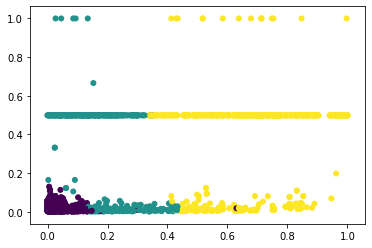

In [52]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_gnb, s=25)